In [12]:
gt_fine_url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_gtFine_trainvaltest.zip"
leftimg8bit_url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_leftImg8bit_trainvaltest.zip"
output_path = "../input/"

!mkdir data
!curl -L "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_gtFine_trainvaltest.zip" -o "./data/P8_Cityscapes_gtFine_trainvaltest.zip"

mkdir: data: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  240M  100  240M    0     0  59.2M      0  0:00:04  0:00:04 --:--:-- 59.2M    0  37.5M      0  0:00:06  0:00:01  0:00:05 37.5M


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns
from glob import glob
import json
import torch
import cv2
from PIL import Image, ImageDraw
import torch  
from torch.utils.data import Dataset  
from torchvision.transforms import Compose, ToTensor, Normalize  

import cv2
from tensorflow import keras  
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate  
from sklearn.model_selection import train_test_split  
from tensorflow.keras.optimizers import Adam  
import tensorflow as tf  
import matplotlib.pyplot as plt  
from tensorflow.keras.preprocessing.image import img_to_array, load_img  


/Users/m/dev/6be709c0/oc-ai-engineer/OC/P8/output/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
json_paths_train = glob('../input/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/**/*.json')
json_paths_test = glob('../input/P8_Cityscapes_gtFine_trainvaltest/gtFine/test/**/*.json')
json_paths_val = glob('../input/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/**/*.json')

def get_file_info(json_path):
    file_path_prefix = json_path.replace("_polygons.json", "")
    
    original_img_path = (
        file_path_prefix
            .replace("P8_Cityscapes_gtFine_trainvaltest/gtFine","P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit")
            .replace("_gtFine", "_leftImg8bit.png")
    )
    
    color_img_path = file_path_prefix + "_color.png"
    instance_ids_img_path = file_path_prefix + "_instanceIds.png"
    label_ids_img_path = file_path_prefix + "_labelIds.png"
    polygons_json_path = json_path
    
    img_width, img_height = Image.open(original_img_path).size
    mask_width, mask_height = Image.open(label_ids_img_path).size
    
    return [original_img_path, color_img_path, instance_ids_img_path, label_ids_img_path, polygons_json_path, f"{img_width}x{img_height}", f"{mask_width}x{mask_height}"]

data_train = [get_file_info(path) for path in json_paths_train]
data_test = [get_file_info(path) for path in json_paths_test]
data_val = [get_file_info(path) for path in json_paths_val]

columns = ["original_img_path", "color_img_path", "instance_ids_img_path", "label_ids_img_path", "polygons_json_path","img_dim", "mask_dim"]
df_train = pd.DataFrame(data_train, columns=columns)
df_test = pd.DataFrame(data_test, columns=columns)
df_val = pd.DataFrame(data_val, columns=columns)

In [3]:
sample_nb = 100
df_train = df_train.sample(n=sample_nb, random_state=42).reset_index()
df_test = df_test.sample(n=sample_nb, random_state=42).reset_index()
df_val = df_val.sample(n=sample_nb, random_state=42).reset_index()

In [4]:
df_train.head()

,index,original_img_path,color_img_path,instance_ids_img_path,label_ids_img_path,polygons_json_path,img_dim,mask_dim
0,2403,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024
1,2865,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024
2,2159,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024
3,507,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024
4,2462,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024


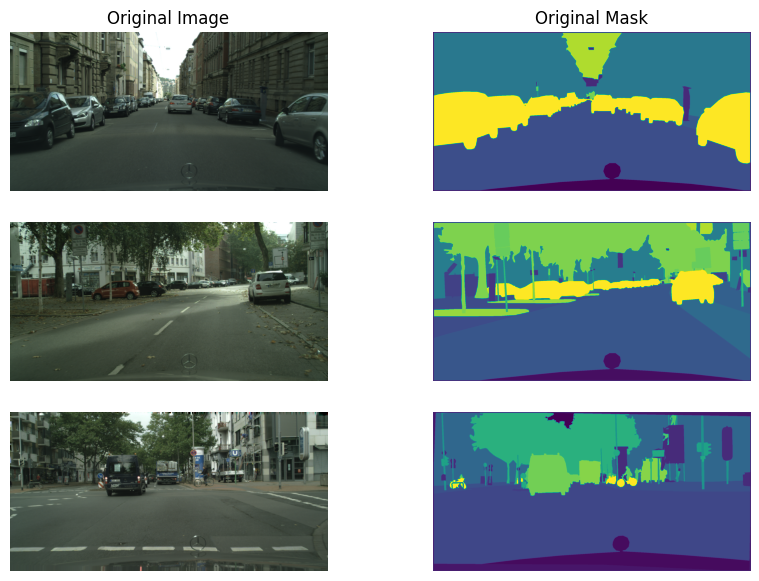

In [5]:
fig,ax = plt.subplots(3,2,figsize=(10,7))

# Set the titles for each column  
ax[0][0].set_title("Original Image")  
ax[0][1].set_title("Original Mask")  

for i in range(3):
    origin_img = plt.imread(df_train["original_img_path"][i])
    mask_img = plt.imread(df_train["label_ids_img_path"][i])
    
    ax[i][0].imshow(origin_img)
    ax[i][0].axis('off')
    
    ax[i][1].imshow(mask_img)
    ax[i][1].axis('off')

In [6]:
df_train.loc[0]["polygons_json_path"]

'../input/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/stuttgart/stuttgart_000128_000019_gtFine_polygons.json'

In [7]:
json_data = json.load(open(df_train.loc[0]["polygons_json_path"]))

In [8]:
category_mapping = {  
    # flat  
    "road": 1, "sidewalk": 1, "parking": 1, "rail track": 1,  
    # human  
    "person": 2, "rider": 2,  
    # vehicle  
    "car": 3, "truck": 3, "bus": 3, "on rails": 3, "motorcycle": 3, "bicycle": 3, "caravan": 3, "trailer": 3,
    # construction  
    "building": 4, "wall": 4, "fence": 4, "guard rail": 4, "bridge": 4, "tunnel": 4,  
    # object  
    "pole": 5, "pole group": 5, "traffic sign": 5, "traffic light": 5,  
    # nature  
    "vegetation": 6, "terrain": 6,  
    # sky  
    "sky": 7,  
    # void  
    "ground": 8, "dynamic": 8, "static": 8,
    # unlabelled
    "ego vehicle": 9, "out of roi": 9, "cargroup":9, "license plate":9
}  

mask = np.zeros((json_data["imgHeight"], json_data["imgWidth"]), dtype=np.uint8)  
  
for obj in json_data['objects']:  
    label = obj['label']  
    polygon = np.array(obj['polygon'], np.int32)  
  
    cv2.fillPoly(mask, [polygon], category_mapping[label])  
  
# Save or use the mask

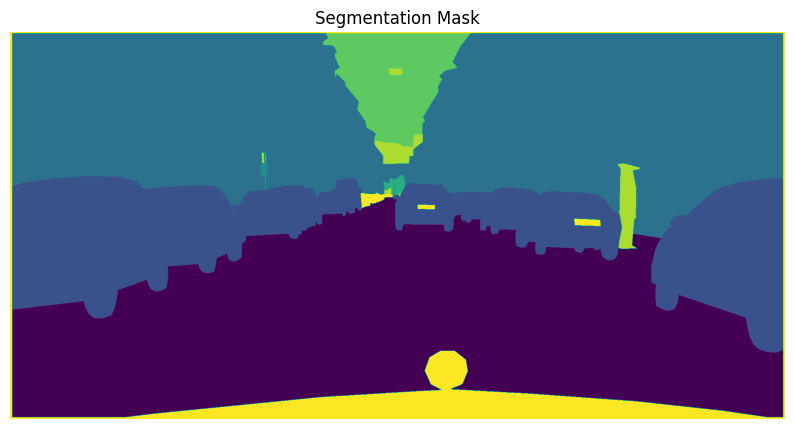

In [9]:
# Load the original image  
original_img = cv2.imread(df_train.loc[0]["original_img_path"])  
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB  
  
# Visualize the mask  
plt.figure(figsize=(10, 10))  
plt.imshow(mask)  # Displaying the mask in grayscale  
plt.title('Segmentation Mask')  
plt.axis('off')  
plt.show()  

In [10]:
def unet_model(input_size=(256, 256, 3)):  
    inputs = Input(input_size)  
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)  
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  
      
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)  
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)  
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  
      
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)  
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)  
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)  
      
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)  
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)  
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)  
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)  
  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)  
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)  
  
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)  
    merge6 = concatenate([drop4, up6])  
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)  
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)  
  
    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)  
    merge7 = concatenate([conv3, up7])  
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)  
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)  
  
    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)  
    merge8 = concatenate([conv2, up8])  
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)  
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)  
  
    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)  
    merge9 = concatenate([conv1, up9])  
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)  
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)  
  
    conv10 = Conv2D(10, 1, activation='softmax')(conv9)  # 9 categories including the 'unlabelled' class  
  
    model = keras.Model(inputs=inputs, outputs=conv10)  
  
    return model  

In [11]:
def create_mask_from_json(json_path, img_shape, mapping):  
    with open(json_path) as f:  
        data = json.load(f)  
      
    mask = np.zeros(img_shape[:2], dtype=np.uint8)  # Assuming img_shape is (height, width, channels)  
      
    for obj in data['objects']:  
        label = obj['label']  
        polygon = np.array(obj['polygon'])  
        if label in mapping:  
            cv2.fillPoly(mask, [polygon], mapping[label])  
    return mask  
  
def load_images_and_masks(df):  
    img_paths = df['original_img_path'].tolist()  
    mask_paths = df['polygons_json_path'].tolist()  
      
    images = []  
    masks = []  
    
    for img_path, mask_path in zip(img_paths, mask_paths):
        img = cv2.imread(img_path)  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        img = cv2.resize(img, (256, 256))  # Resize for the model  
          
        mask = create_mask_from_json(mask_path, img.shape, category_mapping)  
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)  # Keep labels on resize  
          
        images.append(img)  
        masks.append(mask)  
      
    return np.array(images), np.expand_dims(np.array(masks), -1)  

In [12]:
# Example to use these functions  
train_images, train_masks = load_images_and_masks(df_train)  

In [13]:
val_images, val_masks = load_images_and_masks(df_val)  # prepare your test data  

In [14]:
test_images, test_masks = load_images_and_masks(df_test)  # prepare your test data  

In [15]:
sample_mask_check = train_masks[0]
print(np.unique(sample_mask_check))

[4 9]


In [16]:
model = unet_model()  
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  
  
try:  
    history = model.fit(train_images, train_masks, batch_size=32, epochs=10, validation_data=(val_images, val_masks))  
except Exception as e:  
    print(e)  # May offer more insights into which part of the graph execution is failing  
# Assuming train_images, train_masks are prepared as well as their validation counterparts  


2024-02-20 15:32:00.729745: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-20 15:32:00.729773: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-02-20 15:32:00.729777: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-02-20 15:32:00.729823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-20 15:32:00.729842: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2024-02-20 15:32:01.589746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 19s 5s/step - loss: 5.4887 - accuracy: 0.4518 - val_loss: 1.5446 - val_accuracy: 0.4502
Epoch 2/10
4/4 [==============================] - 18s 5s/step - loss: 1.8181 - accuracy: 0.3338 - val_loss: 1.5479 - val_accuracy: 0.4315
Epoch 3/10
4/4 [==============================] - 19s 5s/step - loss: 1.4964 - accuracy: 0.4832 - val_loss: 1.3322 - val_accuracy: 0.4778
Epoch 4/10
4/4 [==============================] - 23s 6s/step - loss: 1.3917 - accuracy: 0.4874 - val_loss: 1.3496 - val_accuracy: 0.5362
Epoch 5/10
4/4 [==============================] - 27s 7s/step - loss: 1.3716 - accuracy: 0.5557 - val_loss: 1.2389 - val_accuracy: 0.5464
Epoch 6/10
4/4 [==============================] - 31s 8s/step - loss: 1.2991 - accuracy: 0.5672 - val_loss: 1.1580 - val_accuracy: 0.5509
Epoch 7/10
4/4 [==============================] - 34s 9s/step - loss: 1.2390 - accuracy: 0.5473 - val_loss: 1.1470 - val_accuracy: 0.5265
Epoch 8/10
4/4 [=============================

In [17]:
# To evaluate on the test set 
model.evaluate(test_images, test_masks)

4/4 [==============================] - 6s 1s/step - loss: 6.7096 - accuracy: 0.0453


[6.709630966186523, 0.045289766043424606]

In [18]:
# def predict_mask(model, img_path):  
#     img = cv2.imread(img_path)  
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
#     img_resized = cv2.resize(img, (256, 256)) / 255.0  # Normalize the image  
  
#     # Model prediction; expand dimensions because model expects a batch  
#     pred = model.predict(np.expand_dims(img_resized, axis=0))  
#     pred_mask = np.argmax(pred, axis=-1)[0]  # Take the argmax to get the most likely class  
  
#     # Resize mask back to original image size  
#     pred_mask_resized = cv2.resize(pred_mask.astype(np.uint8), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)  
      
#     return img, pred_mask_resized  

In [19]:
def display_predicted_mask(model, img_path, mask_path):  
    # Load and preprocess the image  
    img_loaded = load_img(img_path, target_size=(256, 256))
    mask_loaded = load_img(mask_path, target_size=(256, 256))
    img = img_to_array(img_loaded) / 255.0  
    
    img = np.expand_dims(img, axis=0)  # Model expects a batch of images  
    # plt.figure(figsize=(12, 6))  
    
    # Predict the mask  
    pred_mask = model.predict(img)  
    pred_mask = np.argmax(pred_mask, axis=-1)  # Convert categorical to integer mask  
    pred_mask = pred_mask[0]  # Remove batch dimension  
    
    plt.subplot(1, 3, 1)  
    plt.imshow(img_loaded)  
    plt.title('Original Image')  
    plt.axis('off')
    
    plt.subplot(1, 3, 2)  
    plt.imshow(mask_loaded)  
    plt.title('Original Mask')  
    plt.axis('off')
    
    plt.subplot(1, 3, 3)  
    plt.imshow(pred_mask)  
    plt.title('Predicted Mask')  
    plt.axis('off')  
  
    # # Display the mask  
    # plt.imshow(pred_mask, cmap='jet')  
    # plt.axis('off')  
    plt.show()  
    
def display_mask_on_image(model, img_path):  
    # Load and preprocess the image  
    img = load_img(img_path, target_size=(128, 256))  
    img_array = img_to_array(img) / 255.0  
    img_array_expanded = np.expand_dims(img_array, axis=0)  # Model expects a batch of images  
    # Predict the mask  
    pred_mask = model.predict(img_array_expanded)  
    pred_mask = np.argmax(pred_mask, axis=-1)  # Convert categorical to integer mask  
    pred_mask = pred_mask[0]  # Remove batch dimension  
        
    # Mask overlay setup  
    mask = np.zeros((256, 256, 3))  
    mask[np.where(pred_mask == 0)] = [0, 0, 0]  # You can change color for each category  
        
    # Arbitrary color choice for visualization, modify as needed per category  
    for i in range(1, 9):  # Assuming 8 categories + background  
        mask[np.where(pred_mask == i)] = plt.cm.jet(i / 8)[:3]  # Using matplotlib's jet colormap  
        
    # Combine original image and mask  
    combined_img = cv2.addWeighted(src1=img_array, alpha=0.7, src2=mask, beta=0.3, gamma=0)  
        
    plt.figure(figsize=(10, 5))  
        
    plt.subplot(1, 2, 1)  
    plt.imshow(img)  
    plt.title('Original Image')  
    plt.axis('off')  
        
    plt.subplot(1, 2, 2)  
    plt.imshow(combined_img)  
    plt.title('Image with Mask Overlay')  
    plt.axis('off')  
        
    plt.show()  

In [20]:
df_train

,index,original_img_path,color_img_path,instance_ids_img_path,label_ids_img_path,polygons_json_path,img_dim,mask_dim
0,2403,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024
1,2865,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024
2,2159,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024
3,507,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024
4,2462,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024
...,...,...,...,...,...,...,...,...
95,1771,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024
96,744,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024
97,203,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024
98,2683,../input/P8_Cityscapes_leftImg8bit_trainvaltes...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,../input/P8_Cityscapes_gtFine_trainvaltest/gtF...,2048x1024,2048x1024


1/1 [==============================] - 0s 297ms/step


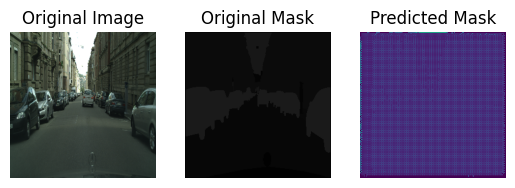

In [21]:
display_predicted_mask(model, df_train.loc[0]["original_img_path"], df_train.loc[0]["label_ids_img_path"])  

In [22]:
display_predicted_mask(model, df_train.loc[0]["label_ids_img_path"])

TypeError: display_predicted_mask() missing 1 required positional argument: 'mask_path'

In [ ]:
display_predicted_mask(model, df_train.loc[0]["color_img_path"])

In [ ]:
# display_mask_on_image(model, df_train.loc[1087]["original_img_path"])  